In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot
import copy
import pywt
from sklearn.svm import SVR
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.model_selection import GridSearchCV,train_test_split,TimeSeriesSplit

### Importing data
Data descriptions:
  - ARKK - ARK Innovation ETF - Yahoo Finance
  - GLD - SPDR Gold Shares ETF - Yahoo Finance
  - R2K - iShares Russell 2000 ETF - Yahoo Finance
  - QQQ - Invesco QQQ Trust Series ETF - Yahoo Finance 
  - BND - Vanguard Total Bond Market ETF
  - XLE - Energy Select Sector SPDR Fund ETF
  - SPY - S&P500 Index - Yahoo Finance
  - USGB - 1-Year US Treasury Historical Price - Bloomberg

In [9]:
# importing CSVs
ARKK=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/ARKK.csv')
R2K=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/RUT2000.csv')
QQQ=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/QQQ.csv')
BND=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/BND.csv')
XLE=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/XLE.csv')
GLD=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/GLD.csv')
SPY=pd.read_csv('/content/drive/MyDrive/data/portfolio_index/SPY.csv')
# importing XLSXs
USGB=pd.read_excel('/content/drive/MyDrive/data/portfolio_index/USGB.xlsx')

In [10]:
# FOR REFERENCE
etfs=[SPY,ARKK,GLD,R2K,QQQ,XLE,BND]
etfNames=['SPY','ARKK','GLD','R2K','QQQ','XLE','BND']
# ADDING DAILY PERFORMANCE
def addDaily(index,indexName):
  index['Return']=100*index['Adj Close'].pct_change().apply(lambda x: np.log(1+x))
  index['Return^2']=index['Return']**2
  index['Realized Vol']=index['Return'].rolling(5).std(ddof=0) #.std()
  index['Variance']=index['Return'].rolling(5).var()
  return index
for i in range(len(etfs)):
  index=etfs[i]
  indexName=etfNames[i]
  index=addDaily(index,indexName)
  index=index[-700:]
SPY=SPY.dropna()
ARKK=ARKK.dropna()
GLD=GLD.dropna()
PFIX=PFIX.dropna()
BND=BND.dropna()
R2K=R2K.dropna()
QQQ=QQQ.dropna()
XLE=XLE.dropna()
R2K=R2K[:-1]
XLE=XLE[:-1]
QQQ=QQQ[:-1]
GLD=GLD[1:]
ARKK=ARKK[1:]

In [11]:
for etf in etfs:
  print(len(etf))

1258
1258
1258
1258
1258
1258
1258


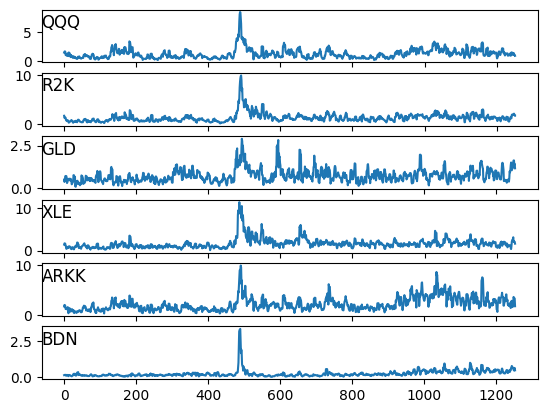

In [13]:
# GRAPHING
column='Realized Vol'
dfGraph = pd.DataFrame({'QQQ': QQQ[column], 'R2K': R2K[column],
                      'GLD': GLD[column],'XLE': XLE[column],'ARKK':ARKK[column],
                      'BDN':BND[column]})
groups=dfGraph.columns.tolist()
values=dfGraph.values
i=1
pyplot.figure()
for group in groups:
  pyplot.subplot(len(groups), 1, i)
  values=dfGraph[group].values
  pyplot.plot(values)
  pyplot.title(group, y=0.5, loc='left')
  i += 1
pyplot.show()

# CNN volatility predictions

In [14]:
# splits data
def cnnTrainTest(df,window):
  realizedVol=df['Realized Vol'].values
  training_len=math.ceil(len(realizedVol)*0.8)
  vol_train=realizedVol[0:training_len]
  vol_test = realizedVol[training_len-window:]
  scaler=MinMaxScaler()
  vol_train_scaled=scaler.fit_transform(vol_train.reshape(-1,1))
  vol_test_scaled=scaler.transform(vol_test.reshape(-1,1))
  vol_x_train=[]
  vol_y_train=[]
  # window of historical prices
  for i in range(window, len(vol_train)):
      vol_x_train.append(vol_train_scaled[i-window:i])
      vol_y_train.append(vol_train_scaled[i])   
  # convert to numpy array for Tensorflow
  vol_x_train, vol_y_train = np.array(vol_x_train), np.array(vol_y_train)
  #test set
  vol_x_test = []
  vol_y_test = realizedVol[training_len:]
  # window of historical prices
  for i in range(window, len(vol_test_scaled)):
    vol_x_test.append(vol_test_scaled[i-window:i])
  # convert to numpy array for Tensorflow
  vol_x_test = np.array(vol_x_test)
  vol_y_test=np.array(vol_y_test)
  return vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler
# generates model
def cnnModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler,steps):
  model = keras.Sequential()
  model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps, 1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.fit(vol_x_train, vol_y_train, batch_size= 1, epochs=3)
  predictions = model.predict(vol_x_test)
  predictions = scaler.inverse_transform(predictions)
  rmse = np.sqrt(np.mean((predictions - vol_y_test)**2))
  print(rmse)
  return predictions,rmse
def cnnGraph(df,predictions,training_len):
  data = df['Realized Vol'].values
  train = data[:training_len]
  validation=pd.DataFrame()
  validation['Realized Vol']=df['Realized Vol'].iloc[training_len:]
  #validation = data[training_len:]
  validation['Predictions'] = predictions
  plt.figure(figsize=(16,8))
  plt.title('Model')
  plt.xlabel('Date')
  plt.ylabel('Volatility')
  plt.plot(train)
  plt.plot(validation[['Realized Vol', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
  plt.show()
def cnnValDF(df,predictions,training):
  data = df['Realized Vol'].values
  train = data[:training_len]
  validation=pd.DataFrame()
  validation['Realized Vol']=df['Realized Vol'].iloc[training_len:]
  validation['Predictions'] = predictions
  return validation

Epoch 1/3
997/997 [==============================] - 3s 2ms/step - loss: 0.0056
Epoch 2/3
997/997 [==============================] - 3s 3ms/step - loss: 0.0041
Epoch 3/3
8/8 [==============================] - 0s 2ms/step
1.8543281507593237


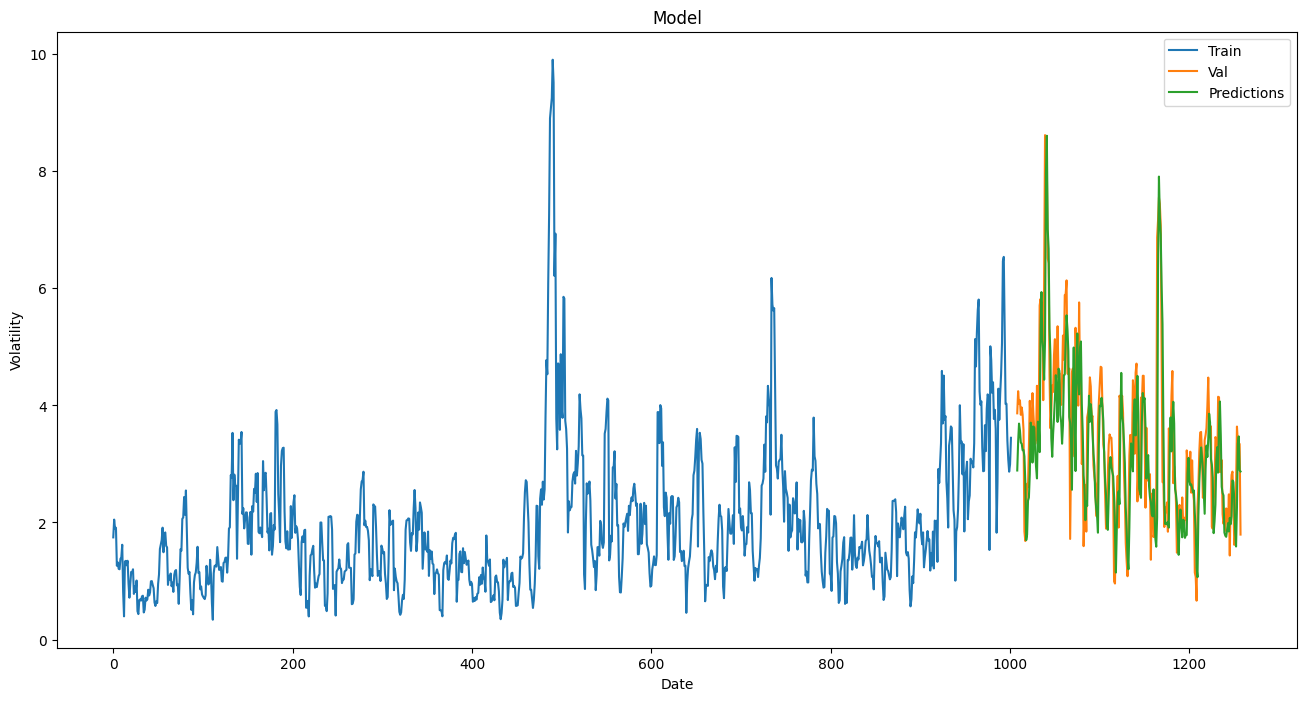

In [15]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=cnnTrainTest(ARKK,5)
ARKKpredictions,rmse=cnnModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler,5)
cnnGraph(ARKK,ARKKpredictions,training_len)
#2.035596

Epoch 1/3
982/982 [==============================] - 2s 2ms/step - loss: 0.0122
Epoch 2/3
982/982 [==============================] - 2s 2ms/step - loss: 0.0105
Epoch 3/3
8/8 [==============================] - 0s 2ms/step
0.3768467027244937


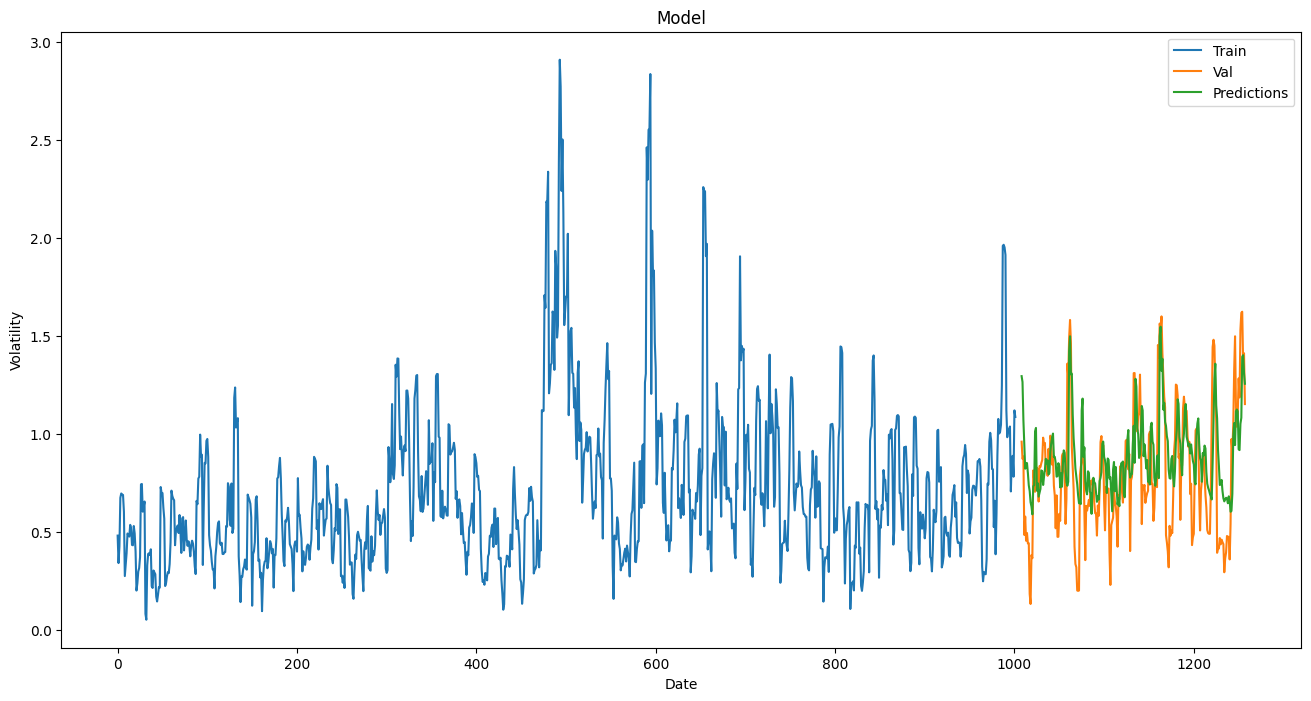

In [16]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=cnnTrainTest(GLD,20)
GLDpredictions,rmse=cnnModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler,20)
cnnGraph(GLD,GLDpredictions,training_len)
#0.41307 pre-ddof

Epoch 1/3
992/992 [==============================] - 3s 2ms/step - loss: 0.0044
Epoch 2/3
992/992 [==============================] - 2s 2ms/step - loss: 0.0034
Epoch 3/3
8/8 [==============================] - 0s 2ms/step
0.6179850573362108


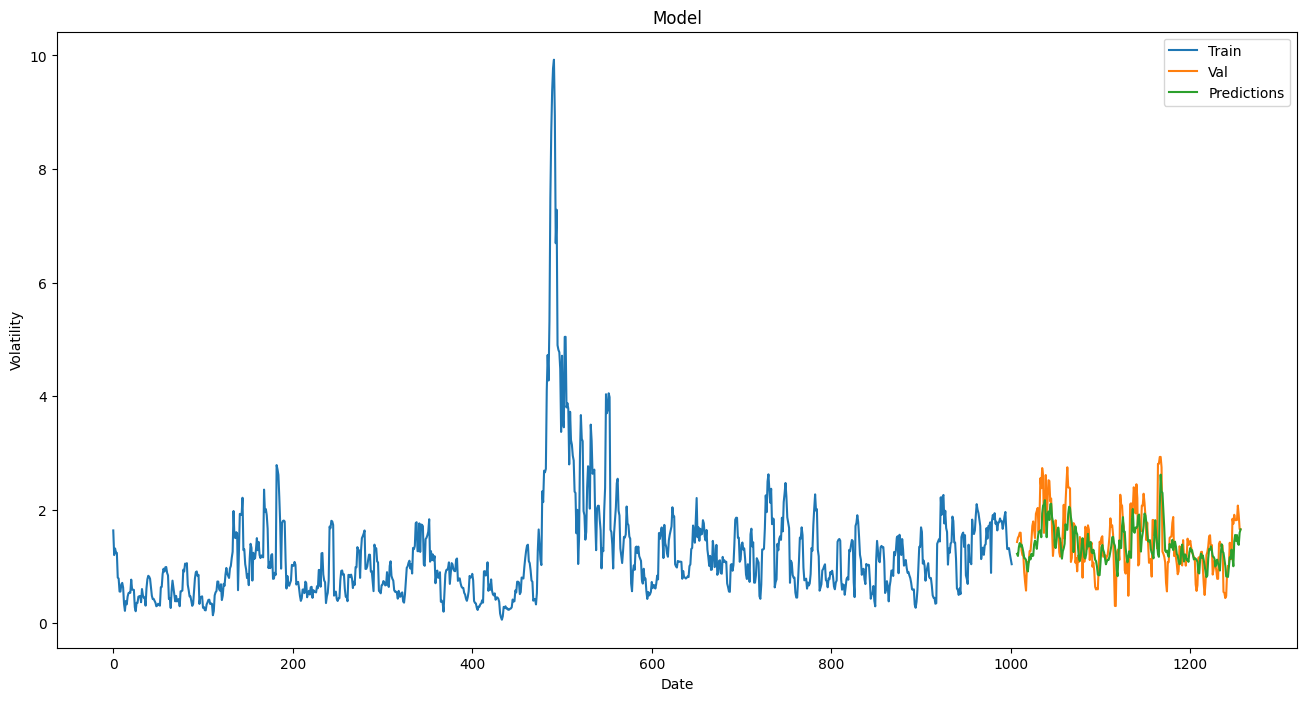

In [17]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=cnnTrainTest(R2K,10)
R2Kpredictions,rmse=cnnModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler,10)
cnnGraph(R2K,R2Kpredictions,training_len)
#0.4053 pre-ddof

Epoch 1/3
992/992 [==============================] - 3s 2ms/step - loss: 0.0046
Epoch 2/3
992/992 [==============================] - 2s 2ms/step - loss: 0.0038
Epoch 3/3
8/8 [==============================] - 0s 3ms/step
0.9401037703602559


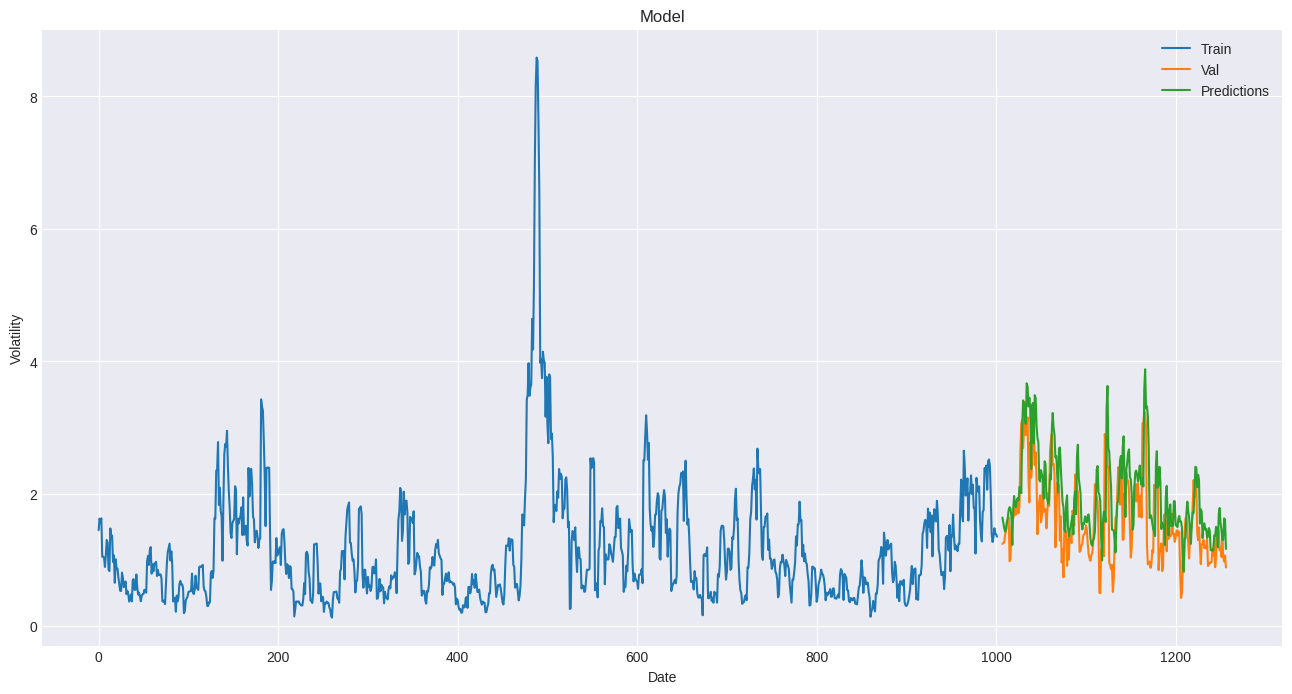

In [80]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=cnnTrainTest(QQQ,10)
QQQpredictions,rmse=cnnModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler,10)
predictions=cnnGraph(QQQ,QQQpredictions,training_len)
#1.87878 pre-ddof

Epoch 1/3
997/997 [==============================] - 3s 2ms/step - loss: 0.0057
Epoch 2/3
997/997 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 3/3
8/8 [==============================] - 0s 2ms/step
1.004414261059923


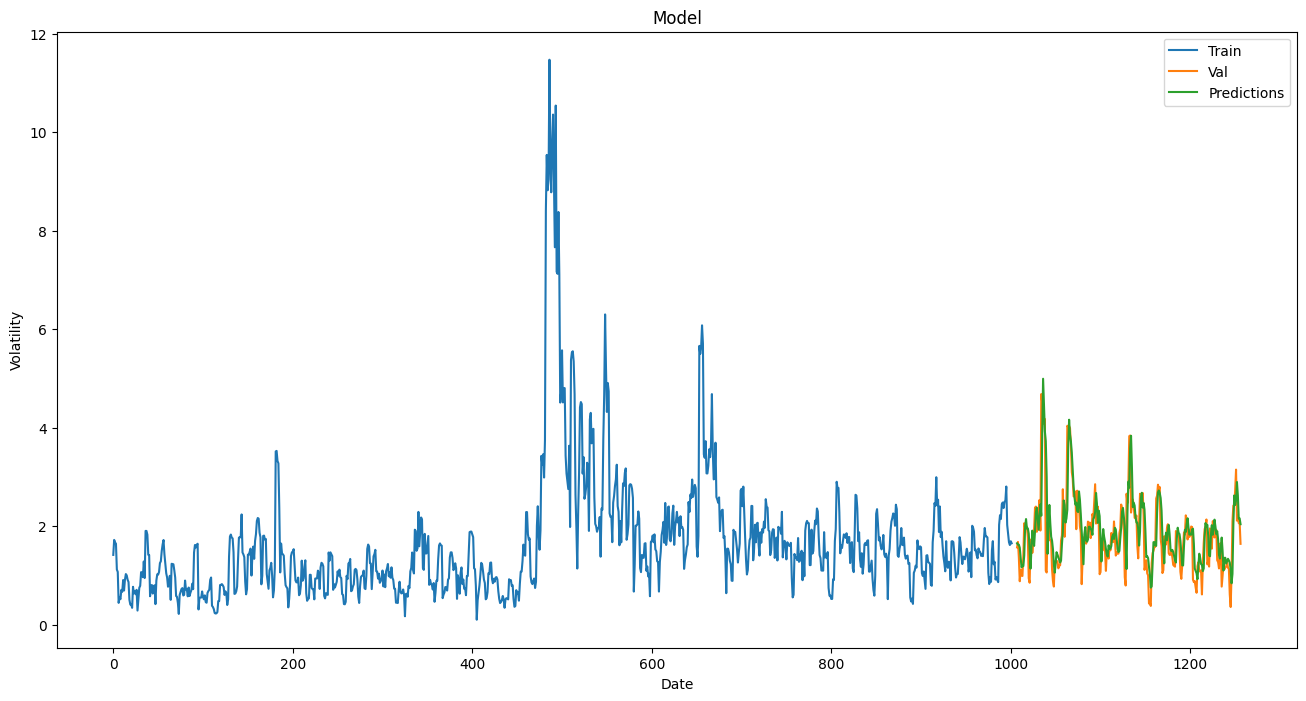

In [19]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=cnnTrainTest(XLE,5)
XLEpredictions,rmse=cnnModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler,5)
cnnGraph(XLE,XLEpredictions,training_len)
#0.8754 pre-ddof

Epoch 1/3
993/993 [==============================] - 2s 2ms/step - loss: 0.0033
Epoch 2/3
993/993 [==============================] - 2s 2ms/step - loss: 0.0023
Epoch 3/3
8/8 [==============================] - 0s 4ms/step
0.2388871930436732


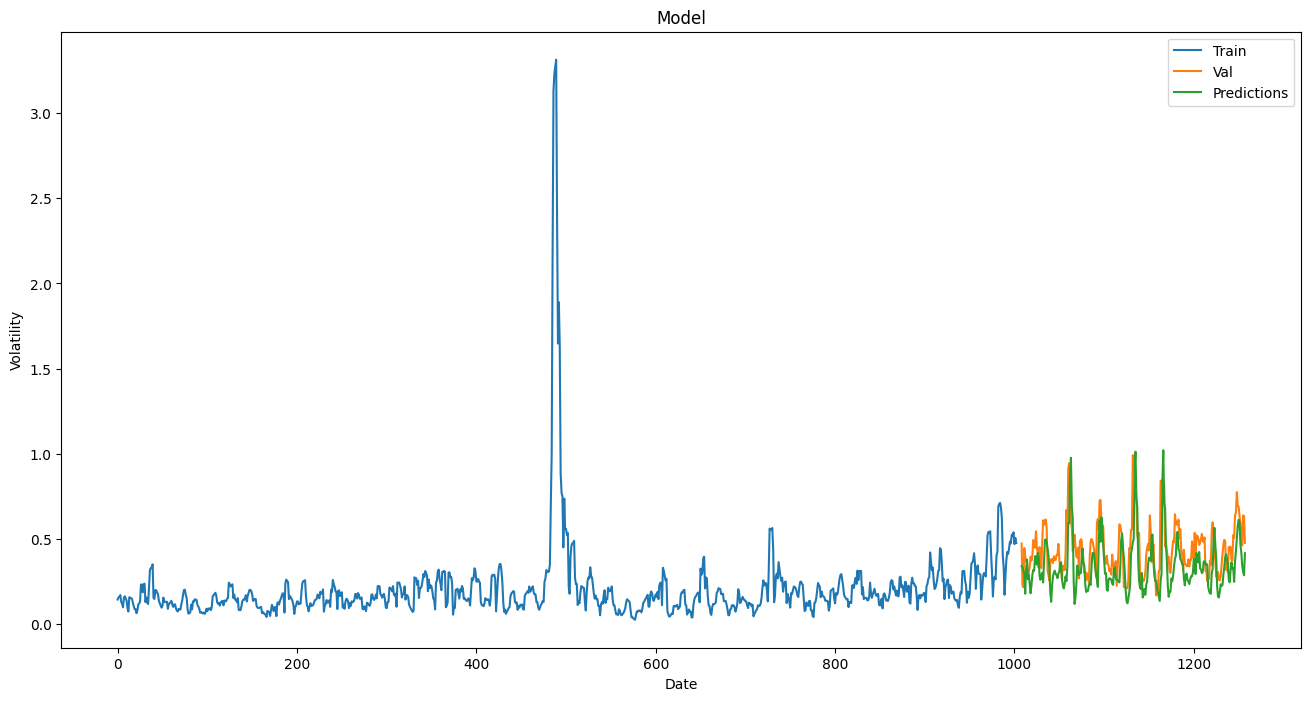

In [20]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=cnnTrainTest(BND,10)
BNDpredictions,rmse=cnnModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler,10)
cnnGraph(BND,BNDpredictions,training_len)

In [93]:
ARKKcnnValDF=cnnValDF(ARKK,ARKKpredictions,training_len)
GLDcnnValDF=cnnValDF(GLD,GLDpredictions,training_len)
R2KcnnValDF=cnnValDF(R2K,R2Kpredictions,training_len)
QQQcnnValDF=cnnValDF(QQQ,QQQpredictions,training_len)
XLEcnnValDF=cnnValDF(XLE,XLEpredictions,training_len)
BNDcnnValDF=cnnValDF(BND[1:],BNDpredictions,training_len)

<ipython-input-94-67156835934f>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


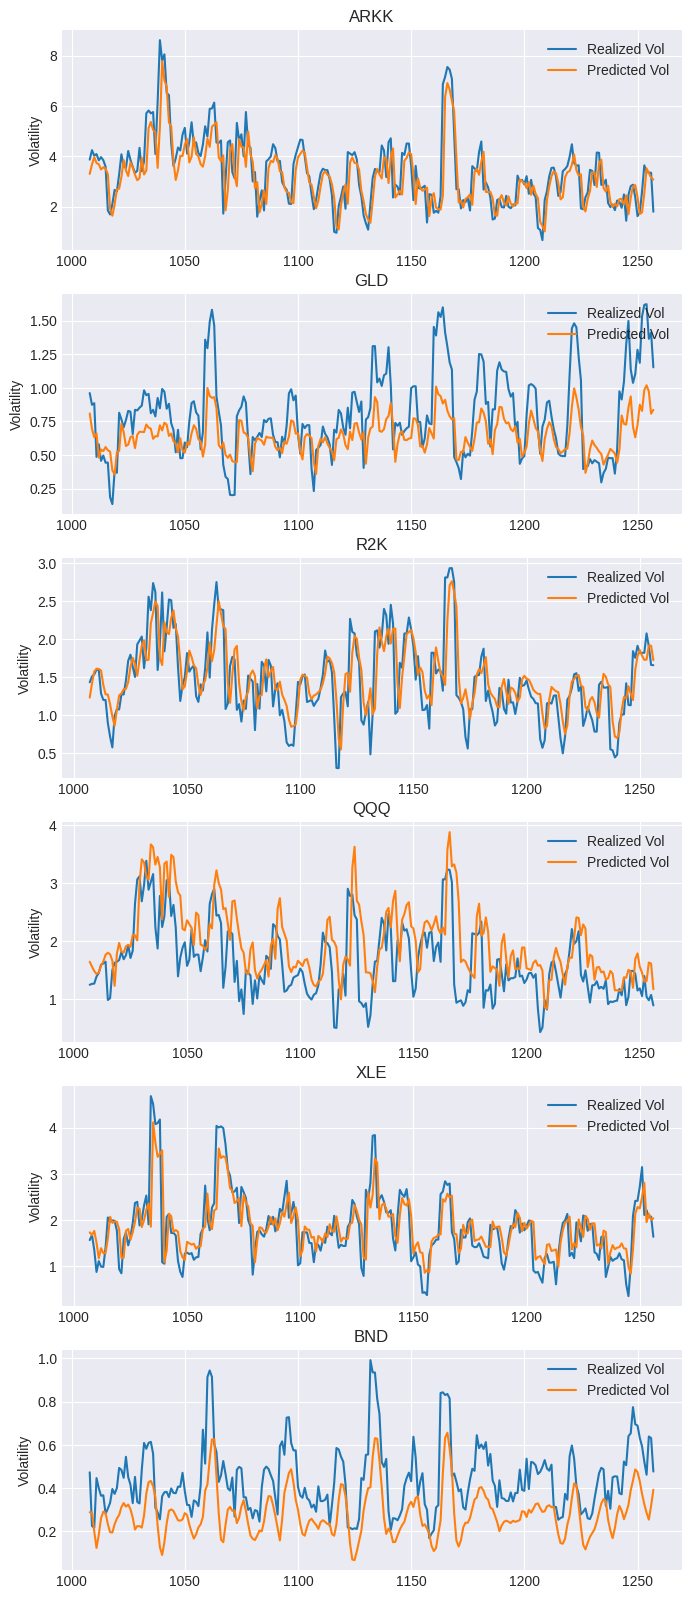

In [94]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(8,20))
palette = plt.get_cmap('Set1')
num=0
cnnDFlist=[ARKKcnnValDF,GLDcnnValDF,R2KcnnValDF,QQQcnnValDF,XLEcnnValDF, BNDcnnValDF]
nameList=['ARKK','GLD','R2K','QQQ','XLE','BND']
for i in range(0,6):
  df=cnnDFlist[i]
  name=nameList[i]
  num+=1
  # Find the right spot on the plot
  plt.subplot(6,1, num)
  # Plot the lineplot
  plt.plot(df[['Realized Vol','Predictions']])
  plt.title(name)
  plt.ylabel('Volatility')
  plt.legend(['Realized Vol', 'Predicted Vol'], loc='upper right')
  plt.tick_params(labelbottom='off')
  #plt.tick_params(labelleft='off')
plt.show()

# LSTM volatility prediction

In [25]:
def lstmTrainTest(df,window):
  realizedVol=df['Realized Vol'].values
  training_len=math.ceil(len(realizedVol)*0.8)
  vol_train=realizedVol[0:training_len]
  vol_test = realizedVol[training_len-window:]
  scaler=MinMaxScaler()
  vol_train_scaled=scaler.fit_transform(vol_train.reshape(-1,1))
  vol_test_scaled=scaler.transform(vol_test.reshape(-1,1))
  vol_x_train=[]
  vol_y_train=[]
  # 60 day window of historical prices
  for i in range(window, len(vol_train)):
      vol_x_train.append(vol_train_scaled[i-window:i])
      vol_y_train.append(vol_train_scaled[i])   
  # convert to numpy array for Tensorflow
  vol_x_train, vol_y_train = np.array(vol_x_train), np.array(vol_y_train)
  # reshape into 3d array for LSTM
  vol_x_train = np.reshape(vol_x_train, (vol_x_train.shape[0], vol_x_train.shape[1], 1))
  #test set
  vol_x_test = []
  vol_y_test = realizedVol[training_len:].reshape(-1,1)
  # 60 day window of historical prices
  for i in range(window, len(vol_test_scaled)):
    vol_x_test.append(vol_test_scaled[i-window:i])
  # convert to numpy array for Tensorflow
  vol_x_test = np.array(vol_x_test)
  vol_y_test=np.array(vol_y_test)
  # reshape into 3d array for LSTM
  vol_x_test = np.reshape(vol_x_test, (vol_x_test.shape[0], vol_x_test.shape[1], 1))
  return vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler
def lstmModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler):
  model = keras.Sequential()
  model.add(layers.LSTM(100, return_sequences=True, input_shape=(vol_x_train.shape[1], 1)))
  model.add(layers.LSTM(100, return_sequences=False))
  model.add(layers.Dense(25))
  model.add(layers.Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(vol_x_train, vol_y_train, batch_size= 1, epochs=3)
  predictions = model.predict(vol_x_test)
  predictions = scaler.inverse_transform(predictions)
  rmse = np.sqrt(np.mean((predictions - vol_y_test)**2))
  print(rmse)
  return predictions,rmse
def lstmGraph(df,predictions,training_len):
  data = df['Realized Vol'].values
  train = data[:training_len]
  validation=pd.DataFrame()
  validation['Realized Vol']=df['Realized Vol'].iloc[training_len:]
  #validation = data[training_len:]
  validation['Predictions'] = predictions
  plt.figure(figsize=(16,8))
  plt.title('Model')
  plt.xlabel('Date')
  plt.ylabel('Volatility')
  plt.plot(train)
  plt.plot(validation[['Realized Vol', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.show()
def lstmValDF(df,predictions,training):
  data = df['Realized Vol'].values
  train = data[:training_len]
  validation=pd.DataFrame()
  validation['Realized Vol']=df['Realized Vol'].iloc[training_len:]
  validation['Predictions'] = predictions
  return validation

Epoch 1/3
982/982 [==============================] - 22s 19ms/step - loss: 0.0073
Epoch 2/3
982/982 [==============================] - 17s 17ms/step - loss: 0.0043
Epoch 3/3
8/8 [==============================] - 1s 13ms/step
0.8369034451204118


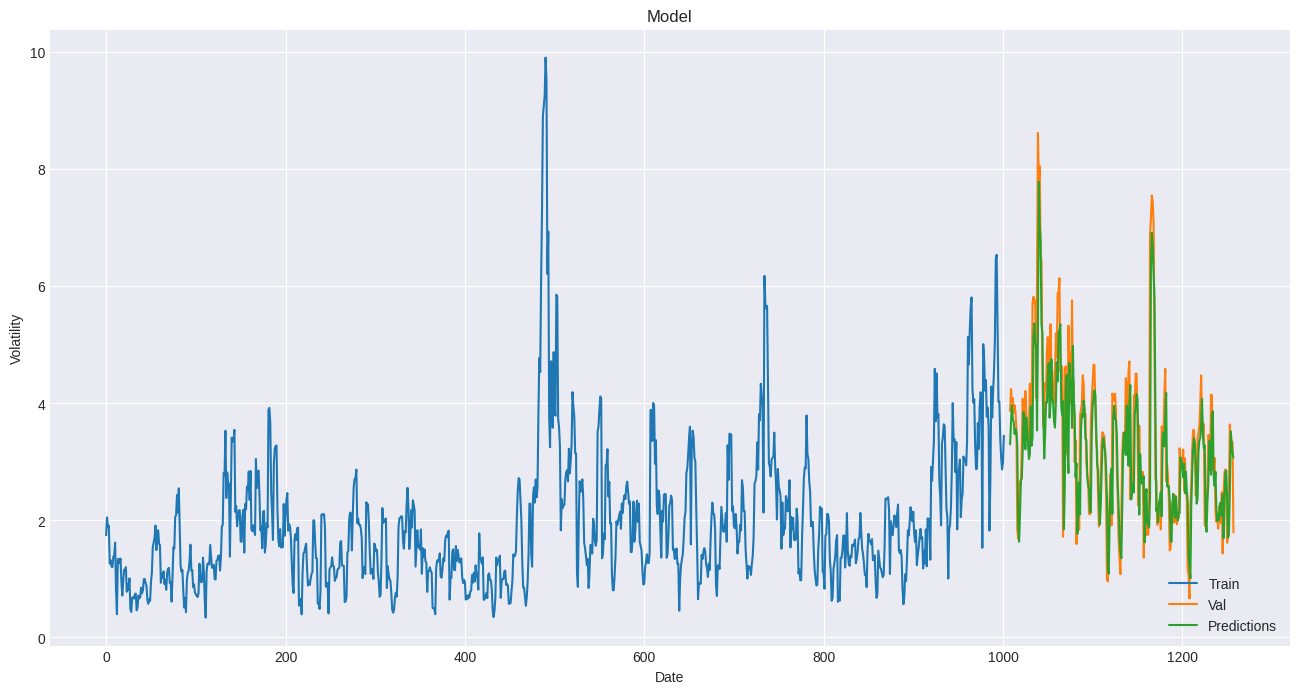

In [26]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=lstmTrainTest(ARKK,20)
ARKKpredictions,rmse=lstmModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler)
lstmGraph(ARKK,ARKKpredictions,training_len)
#0.9985 pre-ddof

Epoch 1/3
982/982 [==============================] - 23s 19ms/step - loss: 0.0099
Epoch 2/3
982/982 [==============================] - 17s 18ms/step - loss: 0.0070
Epoch 3/3
8/8 [==============================] - 1s 18ms/step
0.2687184073382508


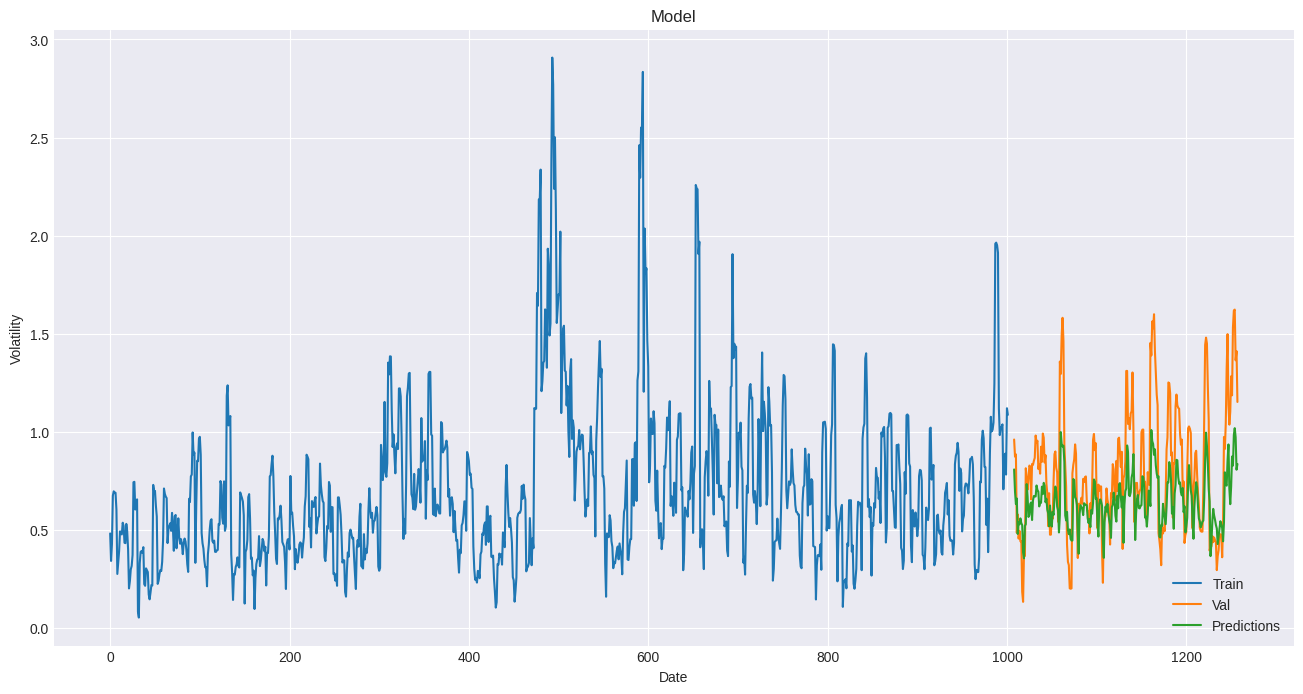

In [27]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=lstmTrainTest(GLD,20)
GLDpredictions,rmse=lstmModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler)
lstmGraph(GLD,GLDpredictions,training_len)
#0.2001 pre-ddof

Epoch 1/3
992/992 [==============================] - 17s 13ms/step - loss: 0.0064
Epoch 2/3
992/992 [==============================] - 11s 11ms/step - loss: 0.0035
Epoch 3/3
8/8 [==============================] - 1s 9ms/step
0.35270448884999983


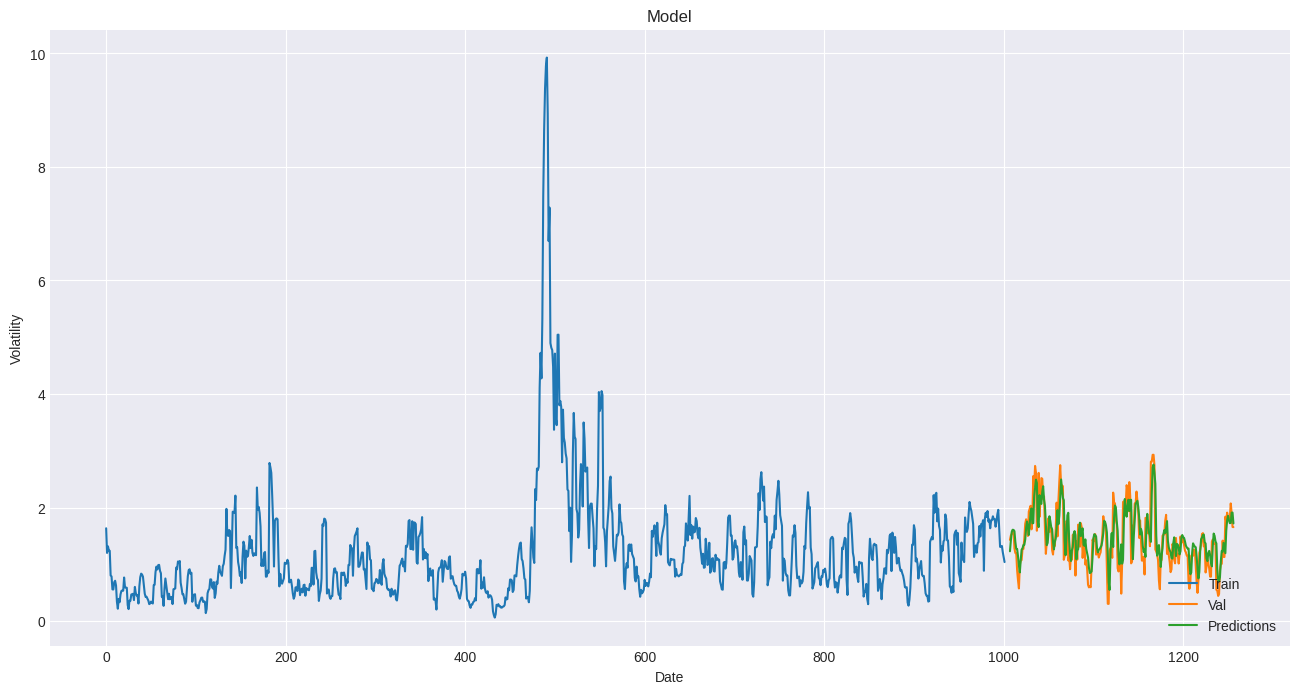

In [28]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=lstmTrainTest(R2K,10)
R2Kpredictions,rmse=lstmModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler)
lstmGraph(R2K,R2Kpredictions,training_len)
#0.2082 pre-ddof

Epoch 1/3
972/972 [==============================] - 28s 25ms/step - loss: 0.0043
Epoch 2/3
972/972 [==============================] - 25s 26ms/step - loss: 0.0030
Epoch 3/3
8/8 [==============================] - 1s 29ms/step
0.4352406871036803


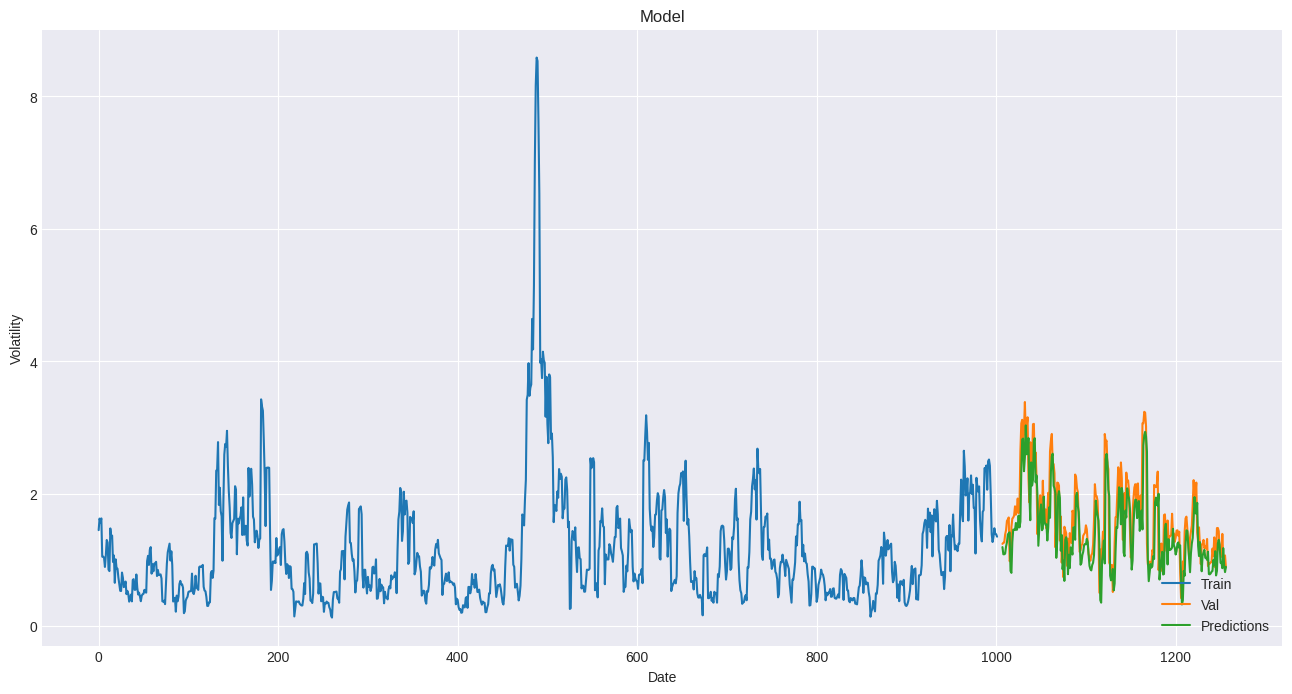

In [29]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=lstmTrainTest(QQQ,30)
QQQpredictions,rmse=lstmModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler)
lstmGraph(QQQ,QQQpredictions,training_len)
#0.809 

Epoch 1/3
997/997 [==============================] - 11s 7ms/step - loss: 0.0062
Epoch 2/3
997/997 [==============================] - 8s 8ms/step - loss: 0.0037
Epoch 3/3
8/8 [==============================] - 1s 6ms/step
0.4756169940098647


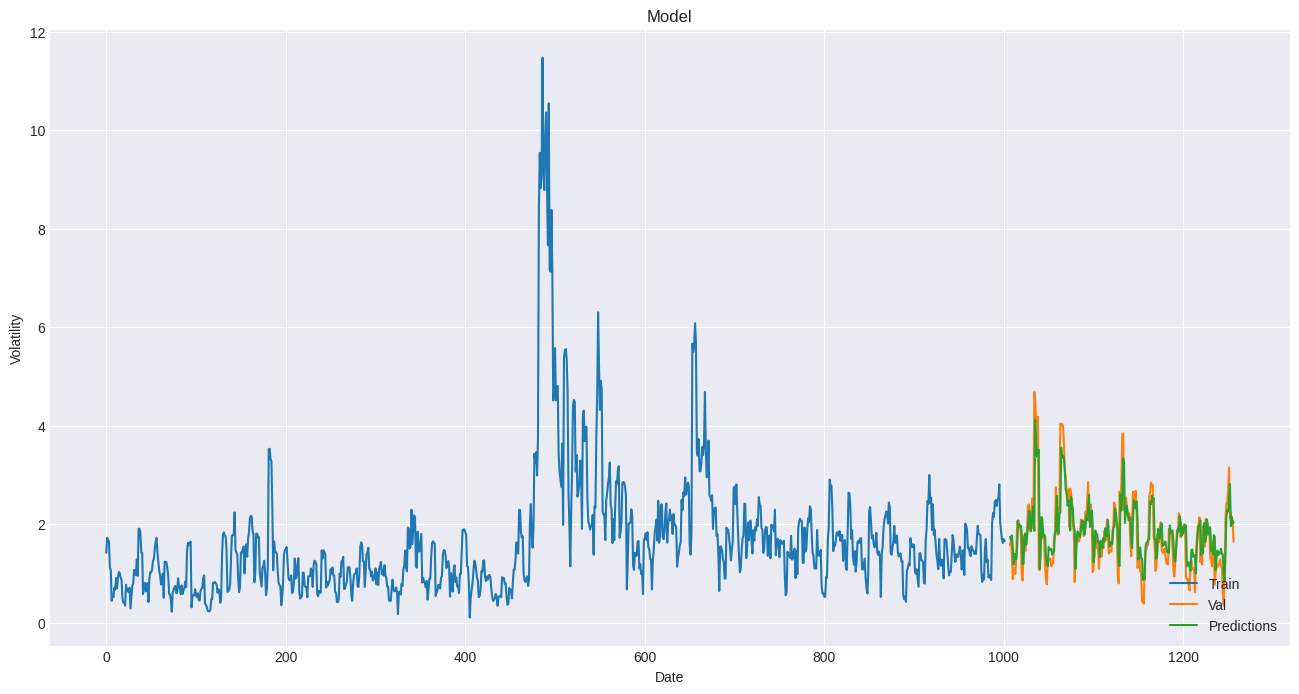

In [30]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=lstmTrainTest(XLE,5)
XLEpredictions,rmse=lstmModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler)
lstmGraph(XLE,XLEpredictions,training_len)
#0.486 pre-ddof

Epoch 1/3
983/983 [==============================] - 21s 18ms/step - loss: 0.0112
Epoch 2/3
983/983 [==============================] - 17s 18ms/step - loss: 0.0030
Epoch 3/3
8/8 [==============================] - 1s 13ms/step
0.18978414465497775


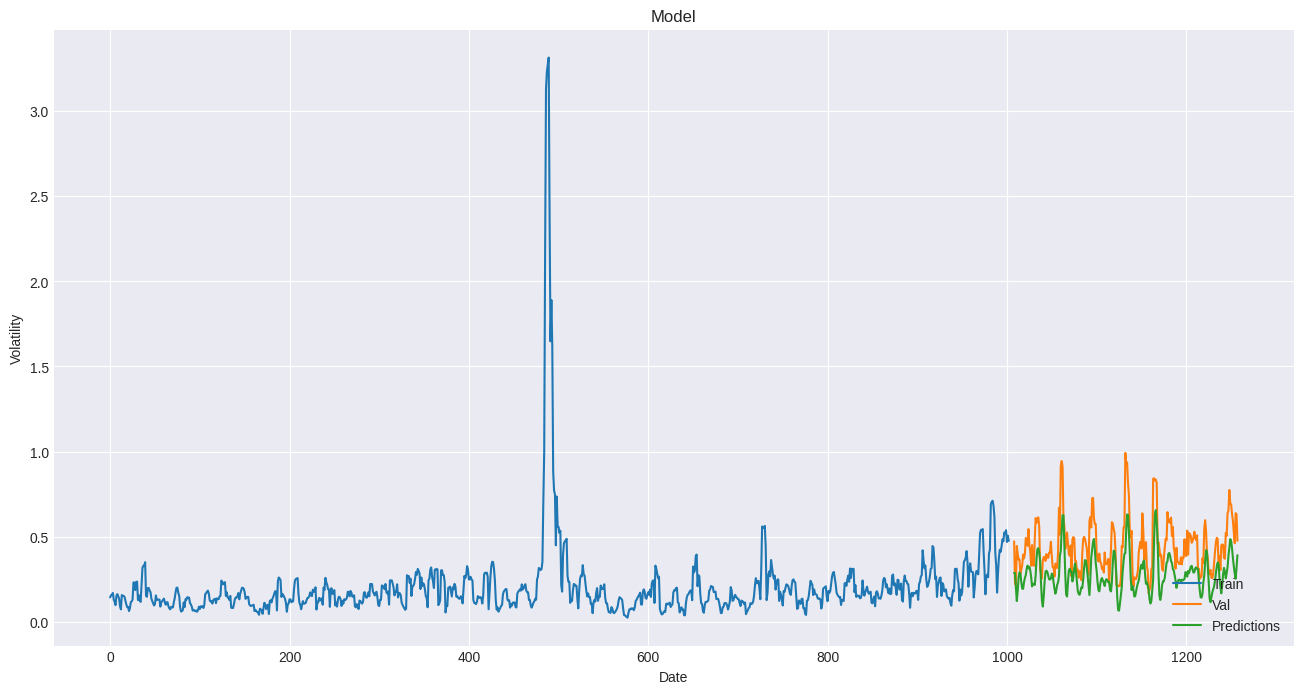

In [31]:
vol_x_train,vol_x_test,vol_y_train,vol_y_test,training_len,scaler=lstmTrainTest(BND,20)
BNDpredictions,rmse=lstmModel(vol_x_train,vol_x_test,vol_y_train,vol_y_test,scaler)
lstmGraph(BND,BNDpredictions,training_len)

In [95]:
# Returns a dataframe of actual and predicted volatility, for graphing
def lstmValDF(df,predictions):
  validation=pd.DataFrame()
  validation['Realized Vol']=df['Realized Vol'].iloc[-250:]
  validation['Predictions'] = predictions
  return validation

In [33]:
# Creating graph dataframes
ARKKlstmValDF=lstmValDF(ARKK,ARKKpredictions)
GLDlstmValDF=lstmValDF(GLD,GLDpredictions)
R2KlstmValDF=lstmValDF(R2K,R2Kpredictions)
QQQlstmValDF=lstmValDF(QQQ,QQQpredictions)
XLElstmValDF=lstmValDF(XLE,XLEpredictions)
BNDlstmValDF=lstmValDF(BND,BNDpredictions)

<ipython-input-34-f1bbb2bd9c2e>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


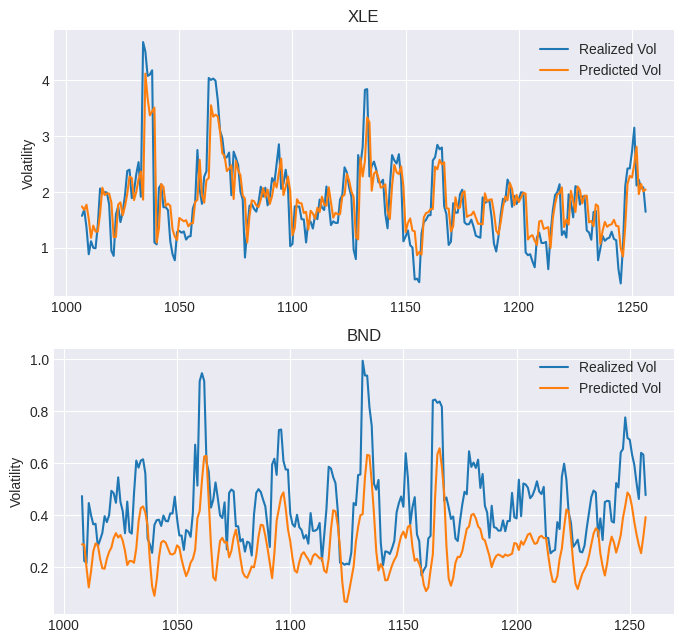

In [34]:
# Graphing actual and predicted volatilities
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(8,20))
palette = plt.get_cmap('Set1')
num=0
lstmDFlist=[ARKKlstmValDF,GLDlstmValDF,R2KlstmValDF,QQQlstmValDF,XLElstmValDF,BNDlstmValDF]
nameList=['ARKK','GLD','R2K','QQQ','XLE','BND']
for i in range(4,6):
  df=lstmDFlist[i]
  name=nameList[i]
  num+=1
  # Find the right spot on the plot
  plt.subplot(5,1, num)
  # Plot the lineplot
  plt.plot(df[['Realized Vol','Predictions']])
  plt.title(name)
  plt.ylabel('Volatility')
  plt.legend(['Realized Vol', 'Predicted Vol'], loc='upper right')
  plt.tick_params(labelbottom='off')
  #plt.tick_params(labelleft='off')
plt.show()

In [35]:
dfList=[ARKK,GLD,R2K,QQQ,XLE,BND]
lstmDFlist=[ARKKlstmValDF,GLDlstmValDF,R2KlstmValDF,QQQlstmValDF,XLElstmValDF,BNDlstmValDF]
QQQlstmValDF

,Realized Vol,Predictions
1007,1.243924,1.195078
1008,1.259928,1.086738
1009,1.264785,1.086512
1010,1.385956,1.096423
1011,1.449260,1.202975
...,...,...
1252,1.394555,0.876722
1253,1.037258,1.179202
1254,0.977308,0.917526
1255,1.069401,0.817926


# Portfolio optimization
Daily risk free rate of return:
  - from 3months
    - $r_1=(1+r_{90})^\frac{1}{90}$
  - [log return from annual rate](https://quant.stackexchange.com/questions/22123/how-to-calculate-daily-risk-free-interest-rates)
    - take the log of $1+r_t^f$ and divide by 365

Expected return
  - $r_a=r_f+β_a(r_m-r_f)$
  - where 
    - $r_a$ = expected return
    - $r_f$ = risk free rate of return
    - [$β$ = the investment's beta](https://www.investopedia.com/terms/b/beta.asp)
    - $r_m$ = the expected market return (for same amount of money?)

Total expected return for a portfolio
  - $E(R_p)=w_1E(R_1)+w_2E(R_2)+...+w_nE(R_n)$

In [36]:
# riskless rate
USGB2=USGB.copy()
USGB2=USGB2[6:]
USGB2=USGB2.iloc[::-1]
USGB2['DailyRate']=(1+USGB2['USGB360D Index                                                  ']).astype('float64')
USGB2['DailyRate']=np.log(USGB2['DailyRate'])/365
USGB2

,Security,USGB360D Index,DailyRate
3799,2008-08-14 00:00:00,2.03504,0.003042
3798,2008-08-15 00:00:00,2.03527,0.003042
3797,2008-08-18 00:00:00,1.99433,0.003005
3796,2008-08-19 00:00:00,1.95365,0.002967
3795,2008-08-20 00:00:00,1.93467,0.002950
...,...,...,...
10,2023-03-20 00:00:00,4.21378,0.004524
9,2023-03-21 00:00:00,4.27056,0.004554
8,2023-03-22 00:00:00,4.18976,0.004511
7,2023-03-23 00:00:00,4.08525,0.004456


In [37]:
ARKK250=ARKK[-250:]
GLD250=GLD[-250:]
R2K250=R2K[-250:]
QQQ250=QQQ[-250:]
XLE250=XLE[-250:]
BND250=BND[-250:]
df250list=[ARKK250,GLD250,R2K250,QQQ250,XLE250,BND250]

#dropping columns
ARKK250=ARKK250.drop(columns=['Open','High','Close','Volume','Low','Return^2'],axis=1)
GLD250=GLD250.drop(columns=['Open','High','Close','Volume','Low','Return^2'],axis=1)
R2K250=R2K250.drop(columns=['Open','High','Close','Volume','Low','Return^2'],axis=1)
QQQ250=QQQ250.drop(columns=['Open','High','Close','Volume','Low','Return^2'],axis=1)
XLE250=XLE250.drop(columns=['Open','High','Close','Volume','Low','Return^2'],axis=1)
BND250=BND250.drop(columns=['Open','High','Close','Volume','Low','Return^2'],axis=1)
columnList=['Adj Close', 'Return','Realized Vol','Variance']

#renaming columns
ARKKdict=['ARKK-'+column for column in columnList]
ARKKdict=dict(zip(columnList,ARKKdict))
ARKK250=ARKK250.rename(columns=ARKKdict)
GLDdict=['GLD-'+column for column in columnList]
GLDdict=dict(zip(columnList,GLDdict))
GLD250=GLD250.rename(columns=GLDdict)
R2Kdict=['R2K-'+column for column in columnList]
R2Kdict=dict(zip(columnList,R2Kdict))
R2K250=R2K250.rename(columns=R2Kdict)
QQQdict=['QQQ-'+column for column in columnList]
QQQdict=dict(zip(columnList,QQQdict))
QQQ250=QQQ250.rename(columns=QQQdict)
XLEdict=['XLE-'+column for column in columnList]
XLEdict=dict(zip(columnList,XLEdict))
XLE250=XLE250.rename(columns=XLEdict)
BNDdict=['BND-'+column for column in columnList]
BNDdict=dict(zip(columnList,BNDdict))
BND250=BND250.rename(columns=BNDdict)

#merging columns
all250=None
all250=ARKK250.merge(GLD250,on='Date')
all250=all250.merge(R2K250,on='Date')
all250=all250.merge(QQQ250,on='Date')
all250=all250.merge(XLE250,on='Date')
all250=all250.merge(BND250,on='Date')
all250

,Date,ARKK-Adj Close,ARKK-Return,ARKK-Realized Vol,ARKK-Variance,GLD-Adj Close,GLD-Return,GLD-Realized Vol,GLD-Variance,R2K-Adj Close,...,QQQ-Realized Vol,QQQ-Variance,XLE-Adj Close,XLE-Return,XLE-Realized Vol,XLE-Variance,BND-Adj Close,BND-Return,BND-Realized Vol,BND-Variance
0,2022-03-31,66.290001,-3.541896,4.243447,22.508556,180.649994,0.038752,0.873639,0.954056,2070.129883,...,1.259928,1.984273,73.250221,-1.364272,1.680846,3.531552,77.488045,0.075478,0.472675,0.279277
1,2022-04-01,67.540001,1.868096,4.024357,20.244308,179.500000,-0.638622,0.885522,0.980187,2091.110107,...,1.264785,1.999600,73.844337,0.807806,1.361011,2.315437,77.320053,-0.217033,0.223942,0.062687
2,2022-04-04,70.500000,4.289268,4.087896,20.888622,180.369995,0.483506,0.485767,0.294963,2095.439941,...,1.385956,2.401092,73.940170,0.129693,0.881964,0.972326,77.378670,0.075782,0.215785,0.058204
3,2022-04-05,66.480003,-5.871151,3.839916,18.431189,179.240005,-0.628455,0.579389,0.419614,2046.040039,...,1.449260,2.625444,72.780647,-1.580617,1.115181,1.554536,76.597366,-1.014847,0.445880,0.248511
4,2022-04-06,63.400002,-4.743730,3.965045,19.651976,179.660004,0.234048,0.456218,0.260169,2016.939941,...,1.590965,3.163960,73.211884,0.590768,0.997657,1.244150,76.362961,-0.306491,0.399394,0.199395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2023-03-21,40.340000,5.398457,2.598565,8.440678,180.369995,-1.905552,1.531745,2.932802,1777.739990,...,1.047930,1.372697,80.389999,3.403456,3.148854,12.394102,73.199997,-0.272858,0.632393,0.499901
244,2023-03-22,38.389999,-4.954655,3.639012,16.553009,183.440002,1.687738,1.617888,3.271953,1727.359985,...,1.394555,2.430979,78.680000,-2.150078,2.113027,5.581103,73.849998,0.884060,0.592970,0.439517
245,2023-03-23,37.799999,-1.548791,3.370236,14.198113,185.740005,1.246022,1.623171,3.293355,1720.290039,...,1.037258,1.344879,77.589996,-1.395049,2.217294,6.145493,74.019997,0.229930,0.522382,0.341104
246,2023-03-24,37.730000,-0.185354,3.356176,14.079901,183.649994,-1.131613,1.364794,2.328327,1734.920044,...,0.977308,1.193914,77.889999,0.385906,2.061024,5.309776,74.169998,0.202444,0.461527,0.266260


# Volatility of portfolio from individual asset volatilities

$$\sigma^2(Rp) = \sum{i=1}^{n} \sum_{j=1}^{n}w_i w_j COV(R_i, R_j) $$

In [38]:
corrCovDF=all250.copy()
corrCovDF=corrCovDF.drop(['Date','ARKK-Adj Close'],axis=1)
colList=corrCovDF.columns.tolist()[1:]
for column in colList:
  if column[-6:]!='Return':
    corrCovDF=corrCovDF.drop(column,axis=1)
weights=np.array([0.2,0.2,0.2,0.2,0.2]).reshape(-1,1)
def calculatePortfolioVariance(index,weights):
  covMatrix=corrCovDF.iloc[index:index+2].cov().reset_index(drop=True)
  corrMatrix=corrCovDF[index:index+3].corr()
  #portfolioVariance=np.dot(weights.T,np.dot(covMatrix,weights))
  return covMatrix,corrMatrix #,portfolioVariance
calculatePortfolioVariance(0,weights)

(   ARKK-Return  GLD-Return  R2K-Return  QQQ-Return  XLE-Return  BND-Return
 0    14.634008   -1.832293    5.450109    2.858441    5.875462   -0.791239
 1    -1.832293    0.229418   -0.682397   -0.357899   -0.735654    0.099069
 2     5.450109   -0.682397    2.029771    1.064562    2.188184   -0.294679
 3     2.858441   -0.357899    1.064562    0.558335    1.147646   -0.154552
 4     5.875462   -0.735654    2.188184    1.147646    2.358961   -0.317677
 5    -0.791239    0.099069   -0.294679   -0.154552   -0.317677    0.042781,
              ARKK-Return  GLD-Return  R2K-Return  QQQ-Return  XLE-Return  \
 ARKK-Return     1.000000    0.186497    0.756493    0.913102    0.815755   
 GLD-Return      0.186497    1.000000   -0.501444    0.570870   -0.416113   
 R2K-Return      0.756493   -0.501444    1.000000    0.424097    0.995386   
 QQQ-Return      0.913102    0.570870    0.424097    1.000000    0.509036   
 XLE-Return      0.815755   -0.416113    0.995386    0.509036    1.000000   
 BND-

# Calculating asset betas
Beta
  - $β$ = $(Covariance(R_e,R_m))/(Variance{R_m})$
  - where 
    - $R_e$ asset return
    - $R_m$ market return
    - Covariance between asset and market
    - Variance - how far market's data points are spread out from their average value

In [39]:
betaDF=pd.DataFrame()
betaDF['SPY-Return']=SPY['Return']
betaDF['SPY-Variance']=SPY['Variance']
betaDF['ARKK-Return']=ARKK['Return']
betaDF['GLD-Return']=GLD['Return']
betaDF['R2K-Return']=R2K['Return']
betaDF['QQQ-Return']=QQQ['Return']
betaDF['XLE-Return']=XLE['Return']
betaDF['BND-Return']=BND['Return']
#betaDF['R2K-Return'] = betaDF['R2K-Return'].shift(1)
#betaDF['QQQ-Return'] = betaDF['QQQ-Return'].shift(1)
#betaDF['XLE-Return'] = betaDF['XLE-Return'].shift(1)
betaDF['RisklessRate']=USGB2['DailyRate']

In [40]:
etfList=['ARKK','GLD','R2K','QQQ','XLE','BND']
for etf in etfList:
  arkkCov=betaDF[[etf+'-Return','SPY-Return']].rolling(5).cov().unstack()
  betaDF[etf+'-cov']=arkkCov['SPY-Return'][etf+'-Return']
betaDF=betaDF.dropna()
for etf in etfList:
  betaDF[etf+'-beta']=betaDF[etf+'-cov']/betaDF['SPY-Variance']
betaDF

<ipython-input-40-d9177e2fadb4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betaDF[etf+'-beta']=betaDF[etf+'-cov']/betaDF['SPY-Variance']
<ipython-input-40-d9177e2fadb4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betaDF[etf+'-beta']=betaDF[etf+'-cov']/betaDF['SPY-Variance']
<ipython-input-40-d9177e2fadb4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,SPY-Return,SPY-Variance,ARKK-Return,GLD-Return,R2K-Return,QQQ-Return,XLE-Return,BND-Return,RisklessRate,ARKK-cov,...,R2K-cov,QQQ-cov,XLE-cov,BND-cov,ARKK-beta,GLD-beta,R2K-beta,QQQ-beta,XLE-beta,BND-beta
10,-0.293716,0.726928,-0.693412,0.653361,-0.503403,0.759337,1.017077,0.012547,0.004524,1.061093,...,0.659327,-0.593906,0.300299,0.068137,1.459695,-0.469102,0.907005,-0.817008,0.413108,0.093732
11,0.818796,0.761062,-0.049732,0.141132,0.868751,2.129685,0.387378,0.037666,0.004404,0.980088,...,0.694154,-0.469631,0.218463,0.075161,1.287790,-0.451654,0.912087,-0.617073,0.287050,0.098758
12,1.064177,0.531882,2.843340,0.093980,1.067202,0.204493,1.561887,-0.326893,0.004515,0.621690,...,0.389742,-0.184081,0.265610,-0.003309,1.168850,-0.718540,0.732760,-0.346094,0.499378,-0.006221
13,0.074011,0.333317,0.674376,0.078246,0.237723,-0.923501,0.122276,-0.239557,0.004404,0.551358,...,0.350538,0.106248,0.127649,-0.014449,1.654157,-0.621140,1.051667,0.318760,0.382966,-0.043349
14,-0.556341,0.489776,-1.037532,-0.195733,-0.616976,-1.595335,-0.476356,-0.252755,0.004495,0.857835,...,0.530635,0.607586,0.344082,-0.006896,1.751484,-0.016504,1.083423,1.240537,0.702528,-0.014081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,1.304507,1.613532,5.398457,-1.905552,1.859407,-1.369129,-2.150078,0.884060,0.003179,2.365946,...,2.528294,-1.103612,-1.628481,0.693305,1.466315,-1.058736,1.566931,-0.683973,-1.009265,0.429681
1253,-1.719346,2.434470,-4.954655,1.687738,-2.874867,1.178835,-1.395049,0.229930,0.003187,5.296668,...,3.552786,-0.985350,-0.573608,0.503539,2.175697,-0.925833,1.459367,-0.404749,-0.235619,0.206837
1254,0.269975,1.750853,-1.548791,1.246022,-0.410132,0.367368,0.385906,0.202444,0.003151,3.854115,...,2.787275,-0.657825,0.196428,0.276858,2.201279,-1.157182,1.591953,-0.375717,0.112190,0.158127
1255,0.654058,1.411108,-0.185354,-1.131613,0.846842,-0.687489,2.108823,-1.043577,0.003124,3.651505,...,2.177968,-0.768100,0.911067,-0.032772,2.587686,-1.016180,1.543445,-0.544324,0.645639,-0.023224


# Calculating expected returns

Expected return
  - $r_a=r_f+β_a(r_m-r_f)$
  - where 
    - $r_a$ = expected return
    - $r_f$ = risk free rate of return
    - [$β$ = the investment's beta](https://www.investopedia.com/terms/b/beta.asp)
    - $r_m$ = the expected market return

In [45]:
expReturns=pd.DataFrame()
expReturns['SPY']=SPY['Adj Close'].pct_change(periods=5)
expReturns=expReturns.dropna()
expReturns['ARKK']=betaDF['RisklessRate']+betaDF['ARKK-beta']*(expReturns['SPY']-betaDF['RisklessRate'])
expReturns['GLD']=betaDF['RisklessRate']+betaDF['GLD-beta']*(expReturns['SPY']-betaDF['RisklessRate'])
expReturns['R2K']=betaDF['RisklessRate']+betaDF['R2K-beta']*(expReturns['SPY']-betaDF['RisklessRate'])
expReturns['QQQ']=betaDF['RisklessRate']+betaDF['QQQ-beta']*(expReturns['SPY']-betaDF['RisklessRate'])
expReturns['XLE']=betaDF['RisklessRate']+betaDF['XLE-beta']*(expReturns['SPY']-betaDF['RisklessRate'])
expReturns['BND']=betaDF['RisklessRate']+betaDF['BND-beta']*(expReturns['SPY']-betaDF['RisklessRate'])
expReturns['R2K'] = expReturns['R2K'].shift(1)
expReturns['QQQ'] = expReturns['QQQ'].shift(1)
expReturns['ARKK'] = expReturns['ARKK'].shift(1)
expReturns['GLD'] = expReturns['GLD'].shift(1)
expReturns['BND'] = expReturns['BND'].shift(1)
expReturns['XLE'] = expReturns['XLE'].shift(1)
#all250['Exp Portfolio Return']=(beta5yr[0]*expReturns['ARKK'])+(beta5yr[1]*expReturns['GLD'])+(beta5yr[2]*expReturns['R2K'])+(beta5yr[3]*expReturns['QQQ'])+(beta5yr[4]*expReturns['XLE'])
#all250=all250.dropna()
expReturns

,SPY,ARKK,GLD,R2K,QQQ,XLE,BND
10,0.020907,NaN,NaN,NaN,NaN,NaN,NaN
11,0.024252,0.028438,-0.003161,0.019384,-0.008861,0.011292,0.006060
12,0.019008,0.029965,-0.004560,0.022508,-0.007843,0.010102,0.006365
13,0.025136,0.021455,-0.005899,0.015135,-0.000501,0.011753,0.004425
14,0.011131,0.038699,-0.008474,0.026208,0.011013,0.012344,0.003505
...,...,...,...,...,...,...,...
1253,0.011114,0.031092,-0.016975,0.033008,-0.009841,-0.016033,0.011359
1254,-0.003634,0.020434,-0.004153,0.014756,-0.000022,0.001319,0.004826
1255,0.014770,-0.011784,0.011002,-0.007650,0.005700,0.002390,0.002078
1256,0.006984,0.033260,-0.008711,0.021099,-0.003216,0.010643,0.002853


### Merging relevant information into one dataframe for further calculations

In [47]:
portfolioDF=None
portfolioDF=pd.DataFrame()
portfolioDF['ARKK-Exp Return']=expReturns['ARKK'].shift(1)
portfolioDF['GLD-Exp Return']=expReturns['GLD'].shift(1)
portfolioDF['R2K-Exp Return']=expReturns['R2K'].shift(1)
portfolioDF['QQQ-Exp Return']=expReturns['QQQ'].shift(1)
portfolioDF['XLE-Exp Return']=expReturns['XLE'].shift(1)
portfolioDF['BND-Exp Return']=expReturns['BND'].shift(1)
portfolioDF['ARKK-Pred Vol']=ARKKlstmValDF['Predictions']
portfolioDF['GLD-Pred Vol']=GLDlstmValDF['Predictions']
portfolioDF['R2K-Pred Vol']=R2KlstmValDF['Predictions']
portfolioDF['QQQ-Pred Vol']=QQQlstmValDF['Predictions']
portfolioDF['XLE-Pred Vol']=XLElstmValDF['Predictions']
portfolioDF['BND-Pred Vol']=BNDlstmValDF['Predictions']
portfolioDF['XLE-Pred Vol']=portfolioDF['XLE-Pred Vol'].shift(2)
portfolioDF['QQQ-Pred Vol']=portfolioDF['QQQ-Pred Vol'].shift(2)
portfolioDF['R2K-Pred Vol']=portfolioDF['R2K-Pred Vol'].shift(1)
portfolioDF=portfolioDF[-249:]
portfolioDF

,ARKK-Exp Return,GLD-Exp Return,R2K-Exp Return,QQQ-Exp Return,XLE-Exp Return,BND-Exp Return,ARKK-Pred Vol,GLD-Pred Vol,R2K-Pred Vol,QQQ-Pred Vol,XLE-Pred Vol,BND-Pred Vol
1009,0.051398,-0.006827,0.033032,-0.019286,0.015508,0.001265,3.676992,0.694394,1.417745,1.195078,1.737916,0.286084
1010,0.117238,-0.001378,0.059031,0.011266,0.055475,-0.005029,3.967470,0.632080,1.572824,1.086738,1.676776,0.198063
1011,0.000889,0.003526,0.002405,0.003029,0.003295,0.003118,3.730554,0.660213,1.610016,1.086512,1.769462,0.122185
1012,-0.007354,0.004375,-0.000286,0.002431,0.002779,0.002757,3.684322,0.479857,1.607293,1.096423,1.514044,0.183339
1013,-0.001764,0.003338,0.001609,0.003654,0.003330,0.003324,3.473939,0.541031,1.585983,1.202975,1.176129,0.260087
...,...,...,...,...,...,...,...,...,...,...,...,...
1253,0.025601,-0.016071,0.036999,-0.005963,-0.032255,0.013274,2.526841,0.983865,1.726175,0.962960,2.500612,0.325179
1254,0.031092,-0.016975,0.033008,-0.009841,-0.016033,0.011359,3.521010,1.018866,1.730131,0.876722,2.808337,0.284817
1255,0.020434,-0.004153,0.014756,-0.000022,0.001319,0.004826,3.338211,0.972709,1.912158,1.179202,1.958764,0.253413
1256,-0.011784,0.011002,-0.007650,0.005700,0.002390,0.002078,3.148238,0.807289,1.912425,0.917526,2.140799,0.316956


In [48]:
def calculateCovMatrix(index,weights):
  covMatrix=portfolioDF.iloc[[index,index+1,index+2],[0,1,2,3,4,5]].cov().reset_index(drop=True)
  covMatrix=covMatrix.rename(columns={'ARKK-Exp Return':0,'GLD-Exp Return':1,'R2K-Exp Return':2,'QQQ-Exp Return':3,'XLE-Exp Return':4,'BND-Exp Return':5})
  return covMatrix 
calculateCovMatrix(0,weights)

,0,1,2,3,4,5
0,0.003404,-0.000122,0.001641,0.000307,0.001553,-0.000243
1,-0.000122,0.000027,-0.000076,0.000060,-0.000027,0.000004
2,0.001641,-0.000076,0.000803,0.000096,0.000728,-0.000114
3,0.000307,0.000060,0.000096,0.000250,0.000230,-0.000036
4,0.001553,-0.000027,0.000728,0.000230,0.000745,-0.000117
5,-0.000243,0.000004,-0.000114,-0.000036,-0.000117,0.000018


# Testing 100 portfolio weights per day, using a covariance matrix calculated from predicted asset volatilities for the following day.

In [49]:
portfolioDF.columns.values.tolist()

['ARKK-Exp Return',
 'GLD-Exp Return',
 'R2K-Exp Return',
 'QQQ-Exp Return',
 'XLE-Exp Return',
 'BND-Exp Return',
 'ARKK-Pred Vol',
 'GLD-Pred Vol',
 'R2K-Pred Vol',
 'QQQ-Pred Vol',
 'XLE-Pred Vol',
 'BND-Pred Vol']

In [51]:
def testPortfolioWeights(index):
  portfolioReturns=[]
  portfolioVolatilities=[]
  portfolioWeights=[]
  portfolioTestCount=100
  calcVol=portfolioDF.iloc[[index+1],[6,7,8,9,10,11]].values.flatten().tolist()
  for i in range(portfolioTestCount-1):
    weights=np.random.random(6)
    weights=weights/np.sum(weights)
    portfolioWeights.append(weights)
    portfolioReturn=portfolioDF.iloc[[index],[0,1,2,3,4,5]].values.flatten().tolist()[:6]
    returns=np.dot(weights,portfolioReturn)
    portfolioReturns.append(returns)
    #portfolioReturns.append(returns).mul(weights,axis=0).mul(weights,axis=1).sum().sum()
    covMatrix=calculateCovMatrix(index,weights)
    portfolioVolatility=((weights[0]**2)*(calcVol[0]**2))+((weights[1]**2)*(calcVol[1]**2))
    portfolioVolatility+=((weights[2]**2)*(calcVol[2]**2))
    portfolioVolatility+=((weights[3]**2)*(calcVol[3]**2))+((weights[4]**2)*(calcVol[4]**2))+((weights[5]**2)*(calcVol[5]**2))
    portfolioVolatility+=2*(weights[0])*(weights[1])*covMatrix[0][1]
    portfolioVolatility+=2*weights[0]*weights[2]*covMatrix[0][2]
    portfolioVolatility+=2*weights[0]*weights[3]*covMatrix[0][3]
    portfolioVolatility+=2*weights[0]*weights[4]*covMatrix[0][4]
    portfolioVolatility+=2*weights[0]*weights[5]*covMatrix[0][5]
    portfolioVolatility+=2*weights[1]*weights[2]*covMatrix[1][2]
    portfolioVolatility+=2*weights[1]*weights[3]*covMatrix[1][3]
    portfolioVolatility+=2*weights[1]*weights[4]*covMatrix[1][4]
    portfolioVolatility+=2*weights[1]*weights[5]*covMatrix[1][5]
    portfolioVolatility+=2*weights[2]*weights[3]*covMatrix[2][3]
    portfolioVolatility+=2*weights[2]*weights[4]*covMatrix[2][4]
    portfolioVolatility+=2*weights[2]*weights[5]*covMatrix[2][5]
    portfolioVolatility+=2*weights[3]*weights[4]*covMatrix[3][4]
    portfolioVolatility+=2*weights[3]*weights[5]*covMatrix[3][5]
    portfolioVolatility+=2*weights[4]*weights[5]*covMatrix[4][5]
    portfolioVolatilities.append(portfolioVolatility)
  dfWeights=pd.DataFrame(portfolioWeights,columns=['ARKK-w','GLD-w','R2K-w','QQQ-w','XLE-w','BND-w'])
  df=pd.DataFrame()
  df['Portfolio-r']=portfolioReturns
  df['Portfolio-v']=portfolioVolatilities
  df=pd.concat([df,dfWeights],axis=1)
  return df

In [77]:
df=testPortfolioWeights(0)
trueReturnDF=betaDF[['SPY-Return','ARKK-Return','GLD-Return','R2K-Return','QQQ-Return','XLE-Return','BND-Return']][-249:]
trueReturnDF

,SPY-Return,ARKK-Return,GLD-Return,R2K-Return,QQQ-Return,XLE-Return,BND-Return
1008,-0.619399,-3.869975,0.800629,-1.990044,-1.247227,-1.364272,0.075478
1009,-1.551094,-3.541896,0.038752,-1.006458,-0.190501,0.807806,-0.217033
1010,0.283002,1.868096,-0.638622,1.008373,2.037954,0.129693,0.075782
1011,0.853017,4.289268,0.483506,0.206845,-2.245441,-1.580617,-1.014847
1012,-1.271184,-5.871151,-0.628455,-2.385729,-2.195049,0.590768,-0.306491
...,...,...,...,...,...,...,...
1252,1.304507,5.398457,-1.905552,1.859407,-1.369129,-2.150078,0.884060
1253,-1.719346,-4.954655,1.687738,-2.874867,1.178835,-1.395049,0.229930
1254,0.269975,-1.548791,1.246022,-0.410132,0.367368,0.385906,0.202444
1255,0.654058,-0.185354,-1.131613,0.846842,-0.687489,2.108823,-1.043577


# Choosing portfolio with best expected return and calculating the true return for that portfolio

In [53]:
def findBestDailyPortfolio(df):
  rf = 0.01 # risk factor
  optimal_risky_port = df.iloc[((df['Portfolio-r']-rf)/df['Portfolio-v']).idxmax()]
  return optimal_risky_port

In [68]:
returns=[]
for i in range(247):
  df=testPortfolioWeights(i)
  best=findBestDailyPortfolio(df)
  bestWeights=best.values.flatten().tolist()[2:]
  trueReturns=trueReturnDF.iloc[[i],[1,2,3,4,5,6]].values.flatten().tolist()
  dailyReturn=bestWeights[0]*trueReturns[0]+bestWeights[1]*trueReturns[1]+bestWeights[2]*trueReturns[2]+bestWeights[3]*trueReturns[3]*bestWeights[4]*trueReturns[4]+bestWeights[5]*trueReturns[5]
  #dailyReturn=best[0]
  returns.append(dailyReturn)

In [69]:
sum(returns)

2.400287061201285

# Graphing robot portfolio returns vs. SPY returns

In [73]:
SPY2=SPY.copy()
SPY2['Return']=SPY2['Return']
SPY2=SPY2[-248:]
SPY2['Return']

1010    0.283002
1011    0.853017
1012   -1.271184
1013   -1.004962
1014    0.502634
          ...   
1253   -1.719346
1254    0.269975
1255    0.654058
1256    0.186810
1257   -0.224718
Name: Return, Length: 248, dtype: float64

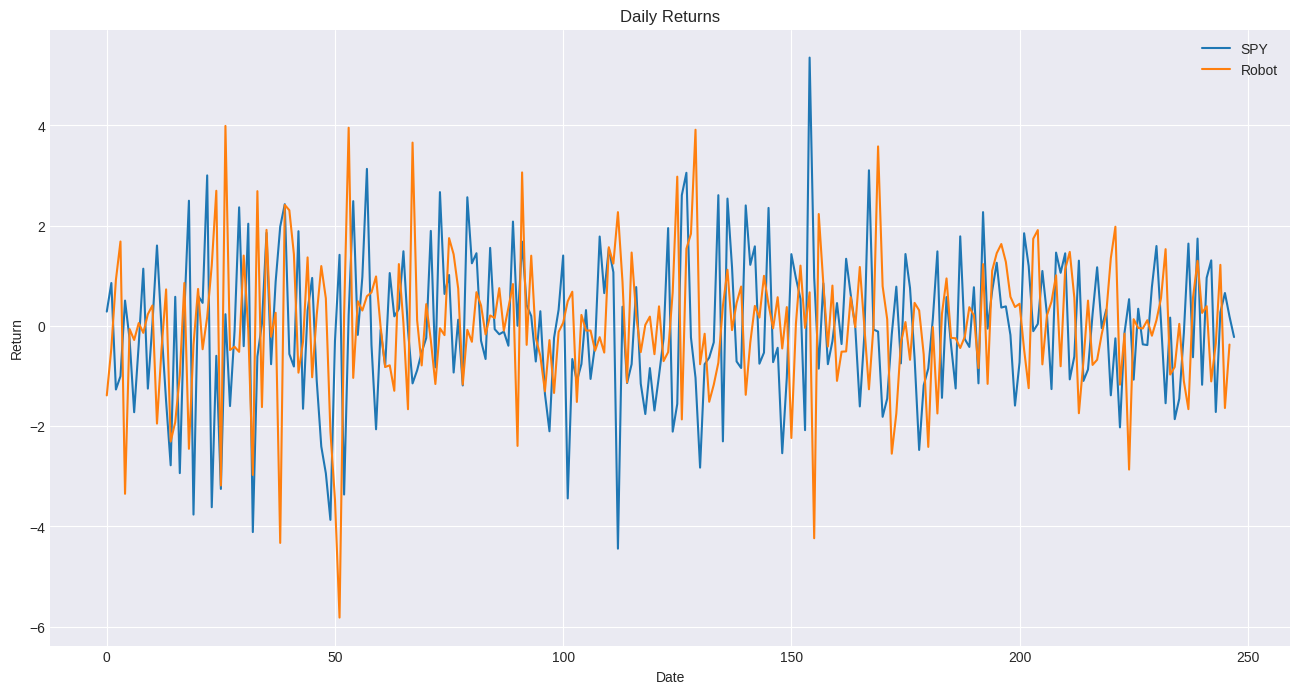

In [75]:
plt.figure(figsize=(16,8))
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
spyreturns=SPY2['Return'].tolist()
plt.plot(spyreturns)
plt.plot(returns)
plt.legend(['SPY', 'Robot'], loc='upper right')
plt.show()